In [10]:
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo
from scipy.stats import bartlett
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pingouin as pg
import seaborn as sns

In [2]:
# data_path = "data_cleaned_feature_31.parquet"
# data = pd.read_parquet(data_path)
# print(data.columns)
# data.shape

In [3]:
data_path = "data_youtube_cleaned_first_final.csv"
data = pd.read_csv(data_path)
print(data.columns)
data.shape

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'channel_id', 'video_title',
       'video_description', 'video_default_thumbnail', 'video_category_id',
       'video_tags', 'video_duration', 'video_dimension', 'video_definition',
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
       'channel_custom_url', 'channel_published_at', 'channel_country',
       'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'engagement_rate', 'time_difference', 'video_duration_seconds',
       'time_difference_days', 'channel_cluster',
       'time_to_trend_difference_seconds', 'is_weekend', 'is_trending',
       'published_hour', 'published_morning', 'published_afternoon',
       'published_evening', 'published_night',
      

(28667, 43)

In [4]:
data.is_trending.value_counts() ## checking how fast videos are trending

is_trending
0    14551
1    14116
Name: count, dtype: int64

In [5]:
data['is_weekend'].value_counts()

is_weekend
False    20692
True      7975
Name: count, dtype: int64

In [17]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from ultralytics import YOLO  # Use ultralytics YOLO package or adapt for YOLOv5
import os
from icecream import ic 
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import torch
from torchvision import models, transforms
import logging

model = YOLO('yolo11n.pt')
model.overrides['verbose'] = False  # Disable verbose logging
# logging.getLogger("ultralytics").setLevel(logging.ERROR)
thumbnail_urls = data['video_default_thumbnail']
def detect_objects(image):
    results = model(image)  # Perform detection
    detections_df = results[0].to_df()  # Convert detections to a DataFrame
    
    # Check if detections_df is empty
    if detections_df.empty:
        return {'contain_1': None, 'contain_2': None, 'contain_3': None}  # No objects detected

    # Count object occurrences using the 'name' column
    object_counts = detections_df['name'].value_counts()

    # Extract the top 3 detected objects (if available)
    top_objects = object_counts.index.tolist()[:3]
    contains_face = int('person' in top_objects)

    # Map to new keys for clarity
    result = {
        'contain_1': top_objects[0] if len(top_objects) > 0 else None,
        'contain_2': top_objects[1] if len(top_objects) > 1 else None,
        'contain_3': top_objects[2] if len(top_objects) > 2 else None,
    }
    
    return result

def analyze_colors(image):
    image = image.resize((100, 100))  # Resize for speed
    pixels = np.array(image).reshape(-1, 3)  # Flatten pixels
    dominant_color = np.mean(pixels, axis=0)  # Average color (RGB)
    brightness = np.mean(np.sqrt(np.sum(pixels**2, axis=1)))  # Brightness metric
    color_diversity = len(np.unique(pixels, axis=0))  # Distinct colors
    return {
        'dominant_color_r': dominant_color[0],
        'dominant_color_g': dominant_color[1],
        'dominant_color_b': dominant_color[2],
        'brightness': brightness,
        'color_diversity': color_diversity
    }

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 34.9MB/s]


In [ ]:
results_list = []
for url in tqdm(thumbnail_urls, desc="Processing Thumbnails", unit="image"):
    try:
        # Download image
        response = requests.get(url, timeout=5)
        image = Image.open(BytesIO(response.content)).convert("RGB")

        # Detect objects
        detection_results = detect_objects(image)
        color_analysis = analyze_colors(image)
        combined_results = {**detection_results, **color_analysis, 'thumbnail_url': url}
        results_list.append(combined_results)
    
    except Exception as e:
        print(f"Failed to process {url}: {e}")
        results_list.append({'thumbnail_url': url, 'error': str(e)})

final_data = pd.merge(data, pd.DataFrame(results_list), how="left", left_on='video_default_thumbnail', right_on='thumbnail_url')

Processing Thumbnails:  48%|████▊     | 11448/23933 [41:03<38:23,  5.42image/s]  

In [21]:
# final_data.to_csv("yolo_image_data.csv", index=False)

In [11]:
final_data = pd.read_csv("yolo_image_data_12082024.csv")
final_data.shape

(28667, 52)

In [12]:
data = final_data.copy()
data.shape

(28667, 52)

In [13]:
data.isnull().sum()

video_id                                        0
video_published_at                              0
video_trending__date                            0
video_trending_country                          0
channel_id                                      0
video_title                                     0
video_description                               0
video_default_thumbnail                         0
video_category_id                               0
video_tags                                      0
video_duration                                  0
video_dimension                                 0
video_definition                                0
video_licensed_content                          0
video_view_count                                0
video_like_count                                0
video_comment_count                             0
channel_title                                   0
channel_description                             0
channel_custom_url                              0


In [14]:
data['tag_count'] = data['video_tags'].apply(lambda x: 0 if x == 'No tags' else len(x.split(',')))
data['tag_count'].value_counts()

tag_count
0      7748
6       669
4       663
23      657
14      652
       ... 
105       1
94        1
93        1
131       1
111       1
Name: count, Length: 110, dtype: int64

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


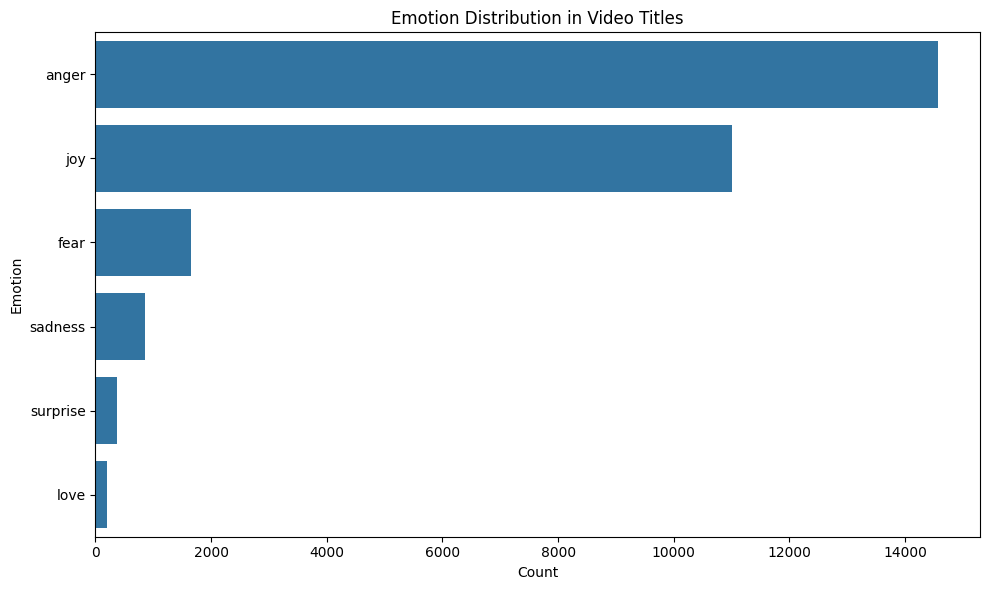

In [15]:
from transformers import pipeline

text_features = ['video_title']

def clean_text_column(column):

    return (
        column.fillna("") 
        .str.replace(r"[^\w\s]", " ", regex=True) 
        .str.lower()  
        .str.strip()  
    )

for text_feature in text_features:
    data[text_feature] = clean_text_column(data[text_feature])
    
    
from transformers import pipeline
import torch
import seaborn as sns
import matplotlib.pyplot as plt

device = 0 if torch.cuda.is_available() else -1

emotion_analyzer = pipeline("text-classification", model="/workspace/saved_model", tokenizer="/workspace/saved_model", device=device)

data['video_title_emotion'] = data['video_title'].apply(lambda x: emotion_analyzer(x)[0]['label'])

label_mapping = {
    'LABEL_0': 'sadness',
    'LABEL_1': 'joy',
    'LABEL_2': 'love',
    'LABEL_3': 'anger',
    'LABEL_4': 'fear',
    'LABEL_5': 'surprise'
}
data['video_title_emotion'] = data['video_title_emotion'].map(label_mapping)

# Plot emotion distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=data['video_title_emotion'], order=data['video_title_emotion'].value_counts().index)
plt.title('Emotion Distribution in Video Titles')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.tight_layout()
plt.show()

In [16]:
categorical_features = [
    'video_category_id', 'is_weekend',
    'video_definition', 'video_dimension', 'video_licensed_content',
    'channel_country', 'channel_have_hidden_subscribers',
    'published_morning', 'published_afternoon', 'published_evening', 'published_night', 'contain_1', 'contain_2',
       'contain_3','video_title_emotion'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference',
    'dominant_color_r', 'dominant_color_g', 'dominant_color_b',
       'brightness', 'color_diversity','tag_count'
]

In [17]:
X_categorical = data[categorical_features]
X_numerical = data[numerical_features]
#X_text = data[embedded_text_columns]?
y = data['is_trending']

In [18]:
# from sklearn.ensemble import IsolationForest
# isolation_forest = IsolationForest(contamination=0.10, random_state=42) 
# outliers = isolation_forest.fit_predict(X_numerical)

# data_cleaned = data[outliers != -1]
# data_cleaned.shape

In [19]:
import numpy as np
#X = np.hstack((X_numerical, X_categorical))
X = pd.concat((X_numerical, X_categorical),axis=1)
X.shape

(28667, 24)

In [20]:
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from feature_engine.pipeline import Pipeline
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import RareLabelEncoder
pipeline = Pipeline([
    ("categorical_imputer", CategoricalImputer(
    variables=['contain_1', 'contain_2', 'contain_3'],
    fill_value="Empty")),
    ("rare_label_encode", RareLabelEncoder(tol=0.005, ignore_format=False)),
    ("num_rare_label_encode", RareLabelEncoder(tol=0.005, ignore_format=True, variables=['tag_count'], replace_with=-1)),
    ("drop_constant_features", DropConstantFeatures(tol=0.90)),
    ("drop_duplicate_features", DropDuplicateFeatures()),
    ("drop_correlated_features", DropCorrelatedFeatures(method='pearson', threshold=0.90))
])

X_final = pipeline.fit_transform(X)
X_final.shape

/usr/local/lib/python3.11/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable video_definition is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable video_dimension is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable video_title_emotion is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


(28667, 20)

In [21]:
# check difference of columns between X and X_final
set(X.columns) - set(X_final.columns)

{'channel_have_hidden_subscribers',
 'video_definition',
 'video_dimension',
 'video_licensed_content'}

In [22]:
X_final

,video_duration_seconds,channel_video_count,channel_video_channel_publish_difference,dominant_color_r,dominant_color_g,dominant_color_b,brightness,color_diversity,tag_count,video_category_id,is_weekend,channel_country,published_morning,published_afternoon,published_evening,published_night,contain_1,contain_2,contain_3,video_title_emotion
0,148.0,43,1366,78.0037,65.1272,45.8112,12.786193,6950,17,Music,False,Unknown,False,False,False,True,person,car,Empty,joy
1,7409.0,5274,2109,90.7597,95.0496,94.4673,13.171799,4574,11,Gaming,False,Indonesia,False,True,False,False,person,person,Empty,joy
2,697.0,36548,2659,87.9835,71.3292,88.6419,13.388571,7131,3,News & Politics,False,Indonesia,False,False,True,False,person,person,Empty,anger
3,687.0,920,1201,108.4453,105.3869,105.3105,13.463079,7201,24,Entertainment,False,Indonesia,True,False,False,False,person,person,person,anger
4,746.0,952,4264,119.5454,95.2846,88.1445,13.349830,7472,0,People & Blogs,False,Germany,True,False,False,False,Rare,person,person,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28662,200.0,318,4503,100.0619,108.3277,101.5744,13.803997,7699,0,Music,False,Rare,True,False,False,False,person,person,Empty,love
28663,4760.0,3383,3131,71.6946,54.5291,59.5860,13.520827,7221,8,Entertainment,False,Unknown,True,False,False,False,person,person,person,anger
28664,4244.0,72,3034,85.1177,52.4568,35.0655,13.370085,7417,0,Entertainment,False,Rare,False,True,False,False,person,person,person,joy
28665,3826.0,21,1133,128.3837,111.1731,107.7519,12.718833,7239,0,Entertainment,False,Rare,False,True,False,False,person,person,person,anger


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

In [24]:
categorical_features = [
    'video_category_id', 'is_weekend',
    'published_morning', 'published_afternoon', 'published_evening', 'published_night', 'contain_1', 'contain_2',
       'video_title_emotion'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference',
    'dominant_color_r', 'dominant_color_b', 'dominant_color_g',
       'brightness', 'color_diversity'
]

In [25]:
X_train_categorical = X_train[categorical_features]
X_test_categorical = X_test[categorical_features]

X_train_numerical = X_train[numerical_features]
X_test_numerical = X_test[numerical_features]

In [26]:
from feature_engine.encoding import DecisionTreeEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import MeanEncoder

encoder = MeanEncoder()
X_train_encode = encoder.fit_transform(X_train_categorical, y_train)
X_test_encode = encoder.transform(X_test_categorical)

In [27]:
# from feature_engine.transformation import LogTransformer

# log_transformer = LogTransformer(variables=numerical_features)

# X_train_log = log_transformer.fit_transform(X_train_numerical)
# X_test_log = log_transformer.transform(X_test_numerical) # di naman gumana hahahaha

In [28]:
# from imblearn.combine import SMOTEENN
# smote_enn = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_combined, X_test_combined)

Model Accuracy: 0.6752703174049529
[[3077 1312]
 [1481 2731]]
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      4389
           1       0.68      0.65      0.66      4212

    accuracy                           0.68      8601
   macro avg       0.68      0.67      0.67      8601
weighted avg       0.68      0.68      0.68      8601



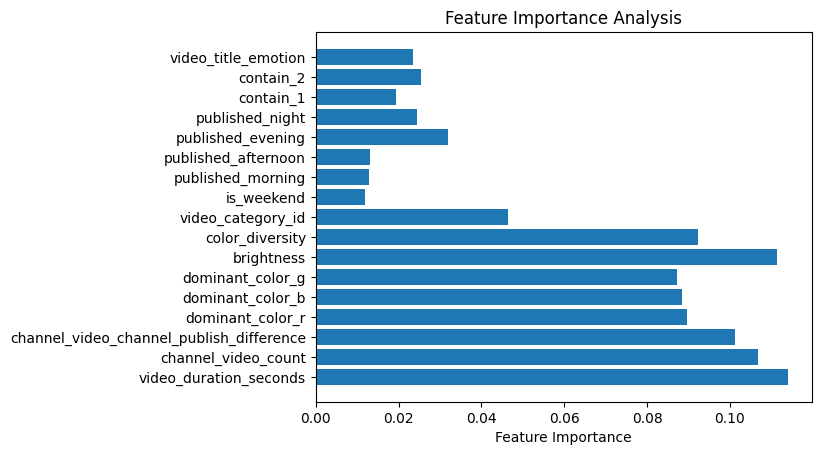

In [29]:
from sklearn.preprocessing import MinMaxScaler
mmx_scaler = MinMaxScaler()
X_train_mmx = mmx_scaler.fit_transform(np.hstack((X_train_numerical, X_train_encode)))
X_test_mmx = mmx_scaler.transform(np.hstack((X_test_numerical, X_test_encode)))

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=300,
        max_features='sqrt',
        n_estimators=1000,
        min_samples_leaf=1,
        min_samples_split=3,
        random_state=33)
model.fit(X_train_mmx, y_train)
accuracy = model.score(X_test_mmx, y_test)
print(f"Model Accuracy: {accuracy}")
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test_mmx)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
feature_importances = model.feature_importances_
feature_names = list(X_train_numerical.columns) + list(X_train_categorical.columns)
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.show()

Model Accuracy: 0.6750377863039182
[[3075 1314]
 [1481 2731]]
              precision    recall  f1-score   support

           0       0.67      0.70      0.69      4389
           1       0.68      0.65      0.66      4212

    accuracy                           0.68      8601
   macro avg       0.68      0.67      0.67      8601
weighted avg       0.68      0.68      0.67      8601



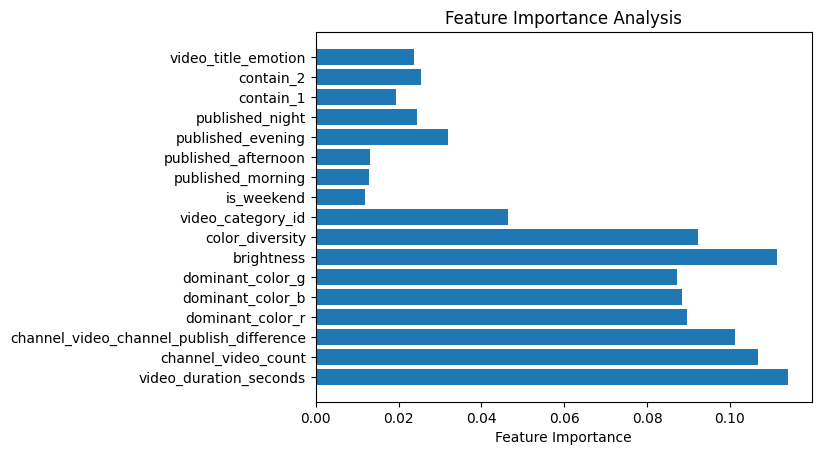

In [30]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mmx_scaler = StandardScaler()
X_train_mmx = mmx_scaler.fit_transform(np.hstack((X_train_numerical, X_train_encode)))
X_test_mmx = mmx_scaler.transform(np.hstack((X_test_numerical, X_test_encode)))

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=300,
        max_features='sqrt',
        n_estimators=1000,
        min_samples_leaf=1,
        min_samples_split=3,
        random_state=33)
model.fit(X_train_mmx, y_train)
accuracy = model.score(X_test_mmx, y_test)
print(f"Model Accuracy: {accuracy}")
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test_mmx)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
feature_importances = model.feature_importances_
feature_names = list(X_train_numerical.columns) + list(X_train_categorical.columns)
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.show()

Model Accuracy: 0.6751540518544356
[[3076 1313]
 [1481 2731]]
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      4389
           1       0.68      0.65      0.66      4212

    accuracy                           0.68      8601
   macro avg       0.68      0.67      0.67      8601
weighted avg       0.68      0.68      0.67      8601



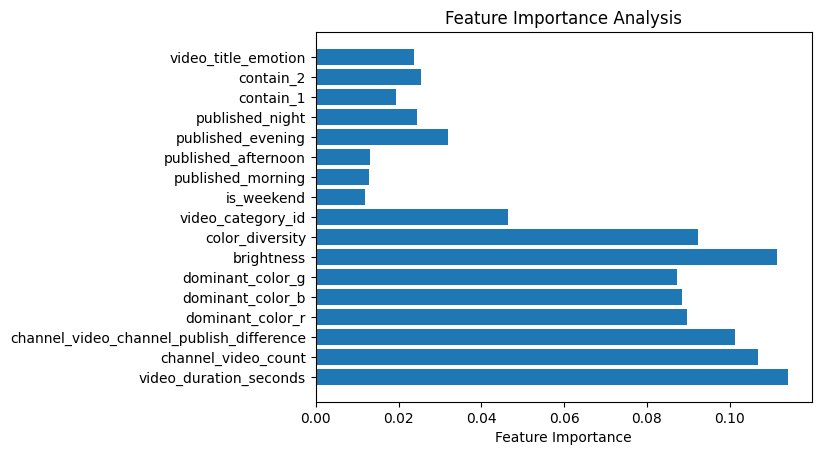

In [31]:
from sklearn.preprocessing import MinMaxScaler
mmx_scaler = StandardScaler()
X_train_mmx = np.hstack((X_train_numerical, X_train_encode))
X_test_mmx = np.hstack((X_test_numerical, X_test_encode))

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=300,
        max_features='sqrt',
        n_estimators=1000,
        min_samples_leaf=1,
        min_samples_split=3,
        random_state=33)
model.fit(X_train_mmx, y_train)
accuracy = model.score(X_test_mmx, y_test)
print(f"Model Accuracy: {accuracy}")
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test_mmx)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
feature_importances = model.feature_importances_
feature_names = list(X_train_numerical.columns) + list(X_train_categorical.columns)
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.show()